In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from scipy import sparse
from tqdm.notebook import tqdm
import warnings

from astropy.timeseries import lombscargle


def vstack(dms):
    """ Custom vertical stack script to stack lightkurve design matrices
    """
    npoints = np.sum([dm.shape[0] for dm in dms])
    ncomps = np.sum([dm.shape[1] for dm in dms])
    if sparse.issparse(dms[0].X):
        X = sparse.lil_matrix((npoints, ncomps))
    else:
        X = np.zeros((npoints, ncomps))
    idx = 0
    jdx = 0
    for dm in dms:
        X[idx:idx+dm.shape[0], jdx:jdx+dm.shape[1]] += dm.X
        idx = idx + dm.shape[0]
        jdx = jdx + dm.shape[1]
    prior_mu = np.hstack([dm.prior_mu for dm in dms])
    prior_sigma = np.hstack([dm.prior_sigma for dm in dms])
    name = dms[0].name
    if sparse.issparse(dms[0].X):
        return lk.SparseDesignMatrix(X.tocsr(), name=name, prior_mu=prior_mu, prior_sigma=prior_sigma)
    else:
        return lk.DesignMatrix(X, name=name, prior_mu=prior_mu, prior_sigma=prior_sigma)
    
    
def SIP(tpfs, sigma=5, min_period=10, max_period=100, nperiods=300):
    """
    Systematics-insensitive periodogram for finding periods in long period NASA's TESS data.
    
    SIP can be used to find the best fitting sinusoid period in long period TESS data, while
    mitigating the instrument and scattered light background systematics.
    
    A description of the concepts behind a SIP is given here in the context of K2 data:
    https://ui.adsabs.harvard.edu/abs/2016ApJ...818..109A/abstract
    
    Parameters
    ----------
    tpfs : lightkurve.TargetPixelFileCollection
        A collection of target pixel files from the TESS mission. This can be  
        generated using lightkurve's search functions, for example:
            tpfs = lk.search_targetpixelfile('TIC 288735205', mission='tess').download_all()
    sigma : int or float
        SIP will run a single first iteration at a period of 27 days to remove significant 
        outliers. Set sigma to a value, above which outliers will be clipped
    min_period : float
        The minimum period for the periodogram
    max_period : float
        The maximum period for the periodogram
    nperiods : int
        The number of periods to fit
    
    Returns
    -------
    r : dict
        Dictionary containing the following entries:
            periods: the periods evaluated
            power: the power at each period (definite as the amplitude of the sinusoid)
            raw_lc: the original light curve from the input target pixel files
            corr_lc: the light curve with the best fitting systematics removed
            period_at_max_power: the best fit period of the sinusoid.    
    """
    
    # Get the un-background subtracted data
    tpfs_uncorr = [(tpf + np.nan_to_num(tpf.flux_bkg))[np.isfinite(tpf.flux_bkg.sum(axis=(1, 2)))] for tpf in tpfs]
    apers = [tpf.pipeline_mask for tpf in tpfs_uncorr]
    lc = lk.LightCurveCollection([tpf.to_lightcurve(aperture_mask=aper) for tpf, aper in zip(tpfs_uncorr, apers)]).stitch()
    lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        bkgs = [lk.DesignMatrix(tpf.flux[:, ~aper], name='bkg').pca(3).append_constant().to_sparse() for tpf, aper in zip(tpfs_uncorr, apers)]
        for bkg in bkgs:
            bkg.prior_mu[-1] = 1
            bkg.prior_sigma[-1] = 0.1

            bkg.prior_mu[:-1] = 0
            bkg.prior_sigma[:-1] = 0.1
        
    # Split at the datadownlink
    bkgs = [bkg.split(list((np.where((np.diff(tpf.time) > 0.3))[0] + 1))) for bkg, tpf in zip(bkgs, tpfs_uncorr)]
    systematics_dm = vstack(bkgs)

    sigma_f_inv = sparse.csr_matrix(1/lc.flux_err[:, None]**2)
    def fit_model(mask=None, return_model=False):
        if mask is None:
            mask = np.ones(len(lc.flux), bool)
        sigma_w_inv = dm.X[mask].T.dot(dm.X[mask].multiply(sigma_f_inv[mask])).toarray()
        sigma_w_inv += np.diag(1. / dm.prior_sigma**2)

        B = dm.X[mask].T.dot((lc.flux[mask]/lc.flux_err[mask]**2))
        B += dm.prior_mu/dm.prior_sigma**2
        w = np.linalg.solve(sigma_w_inv, B)
        werr = ((np.linalg.inv(sigma_w_inv))**0.5).diagonal()
        if return_model:
            return dm.X.dot(w)
        return w, werr

    # Make a dummy design matrix
    period = 27
    ls_dm = lk.DesignMatrix(lombscargle.implementations.mle.design_matrix(lc.time, frequency=1/period, bias=False, nterms=1), name='LS').to_sparse()
    dm = lk.SparseDesignMatrixCollection([systematics_dm, ls_dm]).to_designmatrix(name='design_matrix')

    # Do a first pass at 50 days, just to find ridiculous outliers
    mod = fit_model(return_model=True)
    mask = ~(lc - mod).remove_outliers(return_mask=True, sigma=sigma)[1]

    # Loop over some periods we care about
    periods = 1/np.linspace(1/min_period, 1/max_period, nperiods)
    ws = np.zeros((len(periods), dm.X.shape[1]))
    ws_err = np.zeros((len(periods), dm.X.shape[1]))

    for idx, period in enumerate(tqdm(periods)):
        dm.X[:, -ls_dm.shape[1]:] = lombscargle.implementations.mle.design_matrix(lc.time, frequency=1/period, bias=False, nterms=1)
        ws[idx], ws_err[idx] = fit_model(mask=mask)
    power = (ws[:, -2]**2 + ws[:, -1]**2)**0.5
    
    am = np.argmax(power)
    dm.X[:, -ls_dm.shape[1]:] = lombscargle.implementations.mle.design_matrix(lc.time, frequency=1/periods[am], bias=False, nterms=1)
    mod = dm.X[:, :-2].dot(ws[am][:-2])
    

    r = {'periods':periods, 'power':power, 'raw_lc':lc, 'corr_lc':lc - mod + 1, 'period_at_max_power':periods[am]}
    return r

In [2]:
# Download target pixel files
tpfs = lk.search_targetpixelfile('TIC 288735205', mission='tess').download_all()

In [3]:
# Run SIP
r = SIP(tpfs)

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in sqrt


/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in sqrt


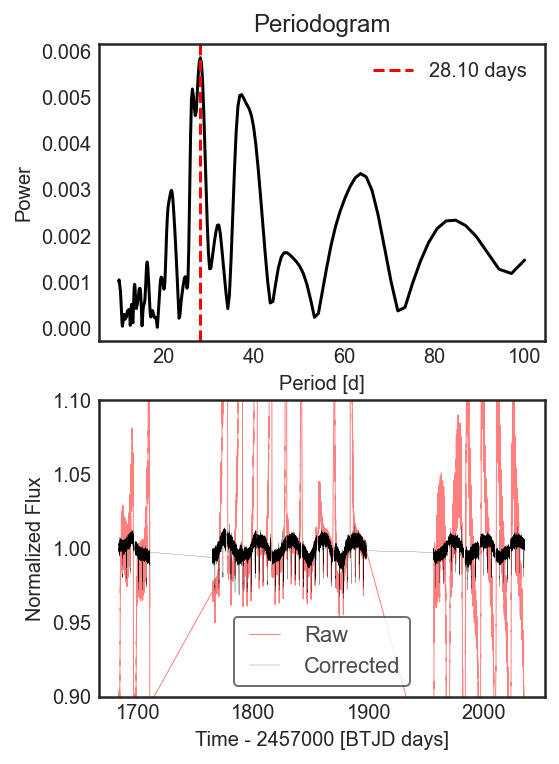

In [4]:
# Example plotting
fig, axs = plt.subplots(2, figsize=(4, 6))
axs[0].plot(r['periods'], r['power'], c='k')
axs[0].set(xlabel='Period [d]', ylabel='Power', title='Periodogram')
axs[0].axvline(r['period_at_max_power'], color='r', ls='--', label=f"{r['period_at_max_power']:0.2f} days")
axs[0].legend()
r['raw_lc'].plot(ax=axs[1], c='r', label='Raw', alpha=0.5)
r['corr_lc'].plot(ax=axs[1], c='k', label='Corrected', lw=0.1)
axs[1].set(ylim=(0.9, 1.1))
plt.savefig('demo.png', dpi=200, bbox_inches='tight')